## Grab Safety Challenge

#### Import necessary Libraries

In [42]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.metrics import classification_report, jaccard_similarity_score, log_loss
from sklearn.linear_model import LogisticRegression

from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt

#machine learning
from catboost import CatBoostRegressor, Pool
import tensorflow as tf
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#support vector machine model
from sklearn.svm import NuSVR, SVR
#kernel ridge model
from sklearn.kernel_ridge import KernelRidge

print('Libraries imported.')

Libraries imported.


### Data Extraction

In [299]:
i=0
features = pd.DataFrame()
while i < 10:
    temp = pd.read_csv('safety/features/part-0000'+ str(i) +'-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv')
    features = features.append(temp)
    i+=1
features.shape

(16135561, 11)

In [303]:
labels = pd.read_csv('safety/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv')

### Data Cleaning

After observing the data, I saw that some retrieved telematic data were wrong

Here some telemetic data had a period of more than 600000000 seconds which is impossible so I am removing them

In [301]:
#index_to_delete = features.loc[features['second'] == float(features[['second']].max(axis=0))].index.item()
index_to_delete = features.loc[features['second'] > 600000000.0].index

features.drop(index_to_delete, inplace=True)

Moreover some bookingID were labeled as a dangerous ride (1) and a normal ride (0) so I decided to delete these duplicates

In [304]:
duplicateRowsDF = labels[labels.duplicated(subset='bookingID')]['bookingID'].values
labels.drop_duplicates(subset='bookingID', keep=False, inplace=True)

index_to_delete = features.loc[features['bookingID'].isin(duplicateRowsDF)].index
features.drop(index_to_delete, inplace=True)

### Exploratory Data Analysis

Let's first do some exploratory data analysis in order to see how the data is articulated and get a first impression of it

In [305]:
print(features.shape)
print(labels.shape)

(15947251, 11)
(19982, 2)


In [8]:
features.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,1202590843006,3.000,353.0,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,0.000000
1,274877907034,9.293,17.0,0.032775,8.659933,4.737300,0.024629,0.004028,-0.010858,257.0,0.190000
2,884763263056,3.000,189.0,1.139675,9.545974,1.951334,-0.006899,-0.015080,0.001122,973.0,0.667059
3,1073741824054,3.900,126.0,3.871543,10.386364,-0.136474,0.001344,-0.339601,-0.017956,902.0,7.913285
4,1056561954943,3.900,50.0,-0.112882,10.550960,-1.560110,0.130568,-0.061697,0.161530,820.0,20.419409


In [306]:
features.describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
count,1.594725e+07,1.594725e+07,1.594725e+07,1.594725e+07,1.594725e+07,1.594725e+07,1.594725e+07,1.594725e+07,1.594725e+07,1.594725e+07,1.594725e+07
mean,8.184397e+11,1.161373e+01,1.689593e+02,6.897941e-02,4.473781e+00,8.958355e-01,-1.704463e-03,3.102588e-04,-2.645680e-04,6.016761e+02,9.006460e+00
std,4.951545e+11,8.699746e+01,1.072968e+02,1.424652e+00,8.128327e+00,3.250140e+00,1.444395e-01,3.397282e-01,1.481788e-01,4.627230e+02,8.106554e+00
min,0.000000e+00,7.500000e-01,0.000000e+00,-7.841969e+01,-7.299412e+01,-7.844842e+01,-4.845575e+01,-7.488861e+01,-5.355445e+01,0.000000e+00,-2.000000e+00
25%,3.779571e+11,3.900000e+00,7.800000e+01,-5.084229e-01,-1.929148e+00,-9.299422e-01,-2.679326e-02,-2.993545e-02,-1.877494e-02,2.410000e+02,1.020000e+00
50%,8.074539e+11,4.243000e+00,1.687686e+02,6.124368e-02,9.082404e+00,7.769897e-01,-6.432411e-04,2.663161e-04,-3.787364e-05,5.200000e+02,7.530000e+00
75%,1.254130e+12,8.000000e+00,2.629526e+02,6.347809e-01,9.709895e+00,2.751022e+00,2.331543e-02,3.144734e-02,1.823250e-02,8.620000e+02,1.548000e+01
max,1.709397e+12,6.070101e+03,3.599995e+02,6.687346e+01,7.505589e+01,7.805576e+01,3.983975e+01,8.031496e+01,6.630078e+01,8.235000e+03,1.480186e+02


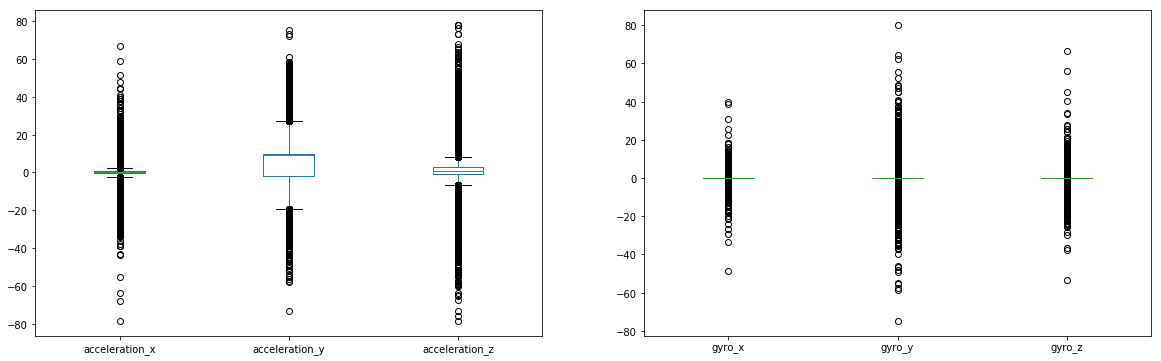

In [307]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**
box0 = features[['acceleration_x','acceleration_y','acceleration_z']]
box1 = features[['gyro_x','gyro_y','gyro_z']]

# Subplot 1: Box plot
box0.plot(kind='box', figsize=(20, 6), ax=ax0) # add to subplot 1


# Subplot 2: Line plot
box1.plot(kind='box', figsize=(20, 6), ax=ax1) # add to subplot 2

plt.show()

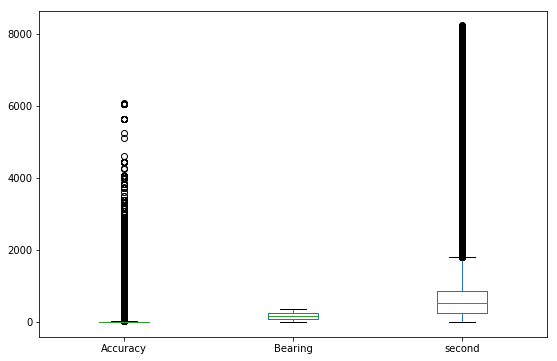

In [66]:
fig = plt.figure() # create figure

ax2 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
box2 = features[['Accuracy','Bearing','second']]

# Subplot 1: Box plot
box2.plot(kind='box', figsize=(20, 6), ax=ax2) # add to subplot 1

plt.show()

As we can see on the graph of these boxplot, there is a lot of outliers in the different columns of the dataset. 

My intuition there was, if a driver is driving dangerously, then he must accelerate more often and stronger than the safe drivers. So I decided to calculate the number of outliers for each booking and see a lot of ouliers was meaning an unsafe drive

### Features engineering

'count_outliers' is the function that will calculate the number of outliers per bookingID for each columns 
I considered that an outliers was each values that was higher or lower than 2.5 the standard deviation of the columns

In [308]:
def count_outliers(col, m = 2.5):
    #Extract data from the column
    data_col = features[['bookingID',col]].set_index('bookingID')
    #Substract of the median
    data_col = data_col - features[[col]].median(axis=0)
    data_col = data_col.abs()
    #Calcul of the new median
    data_col_median = data_col.median(axis=0)
    #We only keep data that are more than twice the median
    data_col = data_col/data_col_median
    data_col = data_col[data_col>m]
    data_col.dropna(inplace=True)
    #We count for each booking the number of outliers
    data_col = data_col.groupby(data_col.index).count()
    data_col.rename(columns={col:col+'_outliers'}, inplace=True)
    return data_col

In [309]:
features_outliers = labels[['bookingID']].set_index('bookingID')
for col in features.columns:
    if(col not in ('bookingID', 'Bearing')):
        temp = count_outliers(col)
        features_outliers = features_outliers.join(temp)
        
features_outliers.head()

,Accuracy_outliers,acceleration_x_outliers,acceleration_y_outliers,acceleration_z_outliers,gyro_x_outliers,gyro_y_outliers,gyro_z_outliers,second_outliers,Speed_outliers
bookingID,,,,,,,,,
111669149733,33.0,29.0,4.0,NaN,12.0,112.0,80.0,NaN,NaN
335007449205,39.0,166.0,9.0,21.0,194.0,398.0,103.0,NaN,NaN
171798691856,367.0,14.0,8.0,NaN,79.0,52.0,150.0,NaN,2.0
1520418422900,12.0,97.0,12.0,12.0,22.0,145.0,47.0,NaN,NaN
798863917116,2.0,137.0,27.0,4.0,220.0,203.0,54.0,NaN,NaN


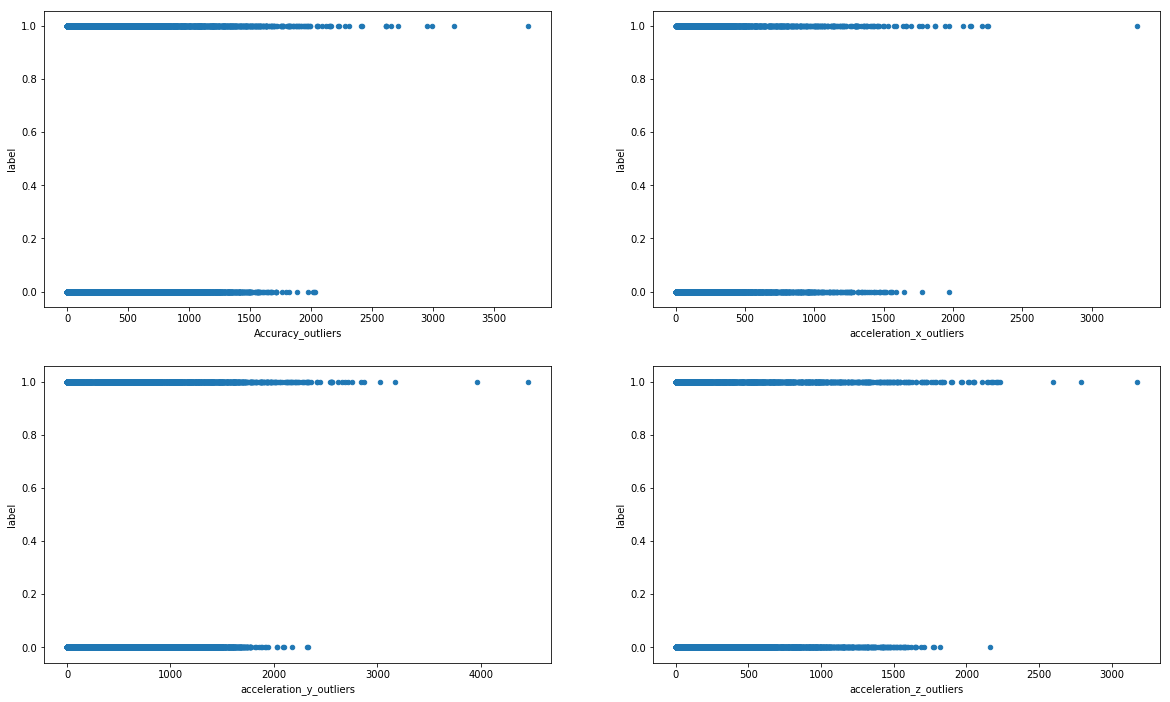

In [310]:
#test = labels.merge(accel_y_outliers2, how='left', left_on='bookingID', right_on=accel_y_outliers2.index)
#test.sort_values(by='acceleration_y', ascending=True, inplace=True)
fig = plt.figure() # create figure

nb_plot = 1
for col in features_outliers.columns:
    if(nb_plot<5):
        ax = fig.add_subplot(2, 2, nb_plot)
        box = labels.merge(features_outliers[[col]], how='left', left_on='bookingID', right_on=features_outliers.index)
        box.plot(kind='scatter', x=col, y='label', figsize=(20, 12), ax=ax)
        nb_plot+=1

plt.show()

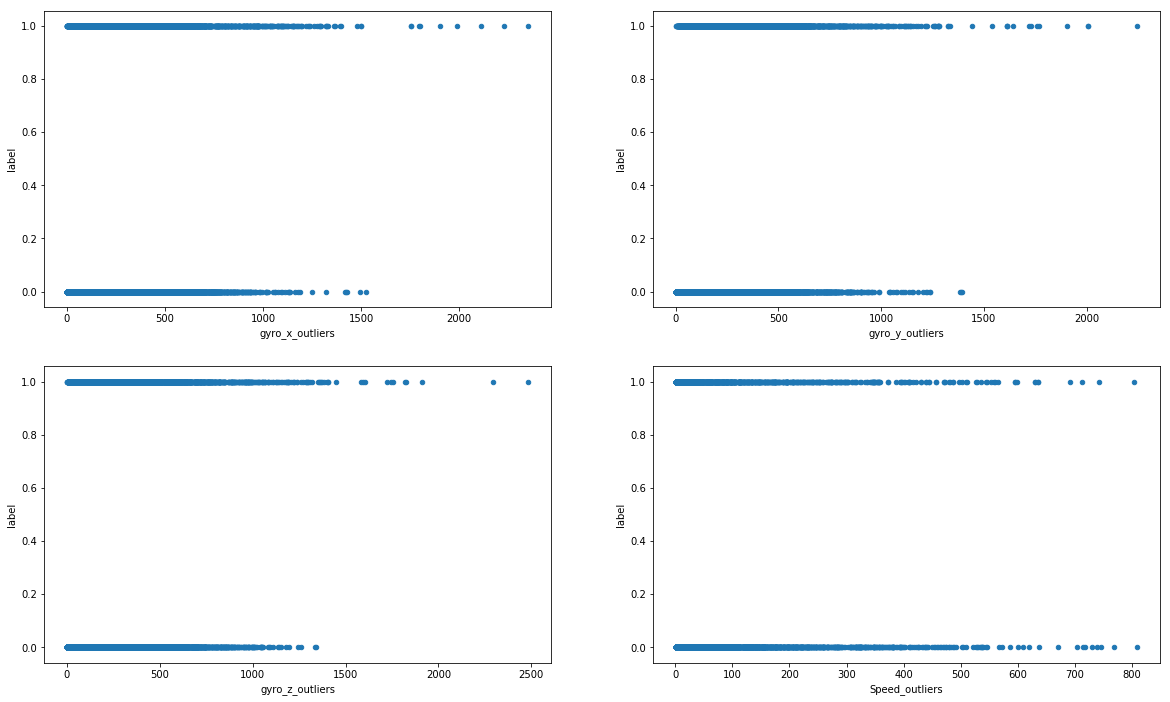

In [311]:
fig = plt.figure() # create figure
nb_plot = 1
for col in features_outliers.columns:
    if(col not in ('Accuracy_outliers','acceleration_x_outliers','acceleration_y_outliers','acceleration_z_outliers','second_outliers')):
        ax = fig.add_subplot(2, 2, nb_plot)
        box = labels.merge(features_outliers[[col]], how='left', left_on='bookingID', right_on=features_outliers.index)
        box.plot(kind='scatter', x=col, y='label', figsize=(20, 12), ax=ax)
        nb_plot+=1
        
plt.show()

#### Conclusion

As we can see on the scatter plots, there is a clear distinction for the bookingID that have a lot of outliers, for any columns except Speed, having a very important number of outliers means that the drive was dangerous. 

But the problem is for a lower number of outliers, the difference between an unsafe and safe drive is not clear, and it will be complicated to have a strong precision with a standard machine learning algorithm

Here I will group the data using groupby on the bookingID and keeping the mean for each columns, then I add the tab of outliers

I decided to only keep acceleration and gyro data because speed was really not relevant between a safe and unsafe drive

In [313]:
features_mean = features.groupby(['bookingID']).mean()
features_final = features_outliers.join(features_mean)
#features_final = features_final[['Accuracy', 'Accuracy_outliers', 'acceleration_x', 'acceleration_x_outliers','acceleration_y','acceleration_y_outliers','acceleration_z','acceleration_z_outliers','gyro_x','gyro_x_outliers','gyro_y','gyro_y_outliers','gyro_z','gyro_z_outliers','second','second_outliers','Speed','Speed_outliers']]
features_final = features_final[['acceleration_x', 'acceleration_x_outliers','acceleration_y','acceleration_y_outliers','acceleration_z','acceleration_z_outliers','gyro_x','gyro_x_outliers','gyro_z','gyro_z_outliers']]
features_final.head()

,acceleration_x,acceleration_x_outliers,acceleration_y,acceleration_y_outliers,acceleration_z,acceleration_z_outliers,gyro_x,gyro_x_outliers,gyro_z,gyro_z_outliers
bookingID,,,,,,,,,,
111669149733,0.114619,29.0,9.771916,4.0,0.038113,NaN,-0.000651,12.0,0.001066,80.0
335007449205,0.234235,166.0,9.551120,9.0,0.872932,21.0,-0.002360,194.0,-0.003000,103.0
171798691856,0.282068,14.0,9.623614,8.0,-0.043747,NaN,-0.009664,79.0,-0.031069,150.0
1520418422900,-0.533975,97.0,9.821743,12.0,0.734085,12.0,-0.001093,22.0,0.000850,47.0
798863917116,0.137313,137.0,9.626067,27.0,1.099706,4.0,0.002212,220.0,-0.001026,54.0


### Data Preprocessing

Now that we have our final tab, let's do some data preprocessing in order for the machine learning algorithms to be more efficient

In [314]:
features_final = features_final.fillna(0)
features_final.head()

,acceleration_x,acceleration_x_outliers,acceleration_y,acceleration_y_outliers,acceleration_z,acceleration_z_outliers,gyro_x,gyro_x_outliers,gyro_z,gyro_z_outliers
bookingID,,,,,,,,,,
111669149733,0.114619,29.0,9.771916,4.0,0.038113,0.0,-0.000651,12.0,0.001066,80.0
335007449205,0.234235,166.0,9.551120,9.0,0.872932,21.0,-0.002360,194.0,-0.003000,103.0
171798691856,0.282068,14.0,9.623614,8.0,-0.043747,0.0,-0.009664,79.0,-0.031069,150.0
1520418422900,-0.533975,97.0,9.821743,12.0,0.734085,12.0,-0.001093,22.0,0.000850,47.0
798863917116,0.137313,137.0,9.626067,27.0,1.099706,4.0,0.002212,220.0,-0.001026,54.0


### Data Normalization

In [315]:
features_final_norm = features_final.copy()
for col in features_final_norm.columns:
    features_final_norm[col] = features_final_norm[col]/features_final_norm[col].max()
    
features_final_norm.head()

,acceleration_x,acceleration_x_outliers,acceleration_y,acceleration_y_outliers,acceleration_z,acceleration_z_outliers,gyro_x,gyro_x_outliers,gyro_z,gyro_z_outliers
bookingID,,,,,,,,,,
111669149733,0.011456,0.008717,0.248954,0.000897,0.000985,0.000000,-0.001357,0.005100,0.000791,0.032206
335007449205,0.023410,0.049895,0.243329,0.002019,0.022553,0.006616,-0.004922,0.082448,-0.002225,0.041465
171798691856,0.028191,0.004208,0.245176,0.001795,-0.001130,0.000000,-0.020151,0.033574,-0.023038,0.060386
1520418422900,-0.053368,0.029155,0.250223,0.002692,0.018966,0.003781,-0.002280,0.009350,0.000630,0.018921
798863917116,0.013724,0.041178,0.245238,0.006057,0.028412,0.001260,0.004612,0.093498,-0.000761,0.021739


In [316]:
labels = labels.set_index('bookingID')
labels.head()

,label
bookingID,
111669149733,0
335007449205,1
171798691856,0
1520418422900,0
798863917116,0


Now we randomly split our data into training and testing data  using the function <b>train_test_split</b>. 

In [317]:
from sklearn.model_selection import train_test_split

X = np.asarray(features_final_norm)
y = np.asarray(labels['label'])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
#x_train, x_test, y_train, y_test = train_test_split(features_final, y, test_size=0.20, random_state=1)

print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 3997
number of training samples: 15985


### 1. Training using logistic Regression

Lets build our model using __LogisticRegression__ from Scikit-learn package. 
Now lets fit our model with train set:

In [117]:
scaler = StandardScaler()
scaler.fit(x_train)
X_train_scaled = scaler.transform(x_train)

In [318]:
LR = LogisticRegression(solver='liblinear').fit(x_train,y_train)
LR

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Now we can predict using our test set:

In [319]:
yhat = LR.predict(x_test)

In [320]:
test = y_test.T
df = pd.Series(test)
grouped = df.groupby(df).count()

print("Number of occurence of each value in result test set :")
print(grouped)
test = yhat.T
df = pd.Series(test)
grouped = df.groupby(df).count()
print("Number of occurence of each value in result test set after going through the ML:")
print(grouped)
print ("Classification report : \n" + classification_report(y_test, yhat))

Number of occurence of each value in result test set :
0    3006
1     991
dtype: int64
Number of occurence of each value in result test set after going through the ML:
0    3905
1      92
dtype: int64
Classification report : 
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      3006
           1       0.65      0.06      0.11       991

   micro avg       0.76      0.76      0.76      3997
   macro avg       0.71      0.52      0.49      3997
weighted avg       0.73      0.76      0.67      3997



### 2. Training using Neural Network

In [321]:
model = tf.keras.models.Sequential([
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    # Only 1 output neuron. 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [322]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])


In [ ]:
history = model.fit(x_train, y_train, epochs=100)

In [324]:
model.evaluate(x_test, y_test)

3997/3997 [==============================] - 0s 72us/sample - loss: 0.5325 - acc: 0.7628


[0.5324727588067331, 0.7628221]

In [325]:
classes = model.predict(x_test)
for i in range(len(classes)):
    if classes[i] > 0.5:
        classes[i] = 1
    else:
        classes[i] = 0

In [326]:
test = y_test.T
df = pd.Series(test)
grouped = df.groupby(df).count()

print("Number of occurence of each value in result test set :")
print(grouped)
test = classes.T
test = test[0][1:]
df = pd.Series(test)
grouped = df.groupby(df).count()
print("Number of occurence of each value in result test set after going through the ML:")
print(grouped)

Number of occurence of each value in result test set :
0    3006
1     991
dtype: int64
Number of occurence of each value in result test set after going through the ML:
0.0    3875
1.0     121
dtype: int64


In [327]:
print ("Classification report : \n" + classification_report(y_test, classes))

Classification report : 
              precision    recall  f1-score   support

           0       0.77      0.99      0.86      3006
           1       0.68      0.08      0.15       991

   micro avg       0.76      0.76      0.76      3997
   macro avg       0.72      0.53      0.50      3997
weighted avg       0.74      0.76      0.69      3997



### Conclusion

To conclude, the neural network gave us the best accuracy, but overall it is not a very good fit for our data. the f1 score for driving considered dangerously is very low. So my first intuition was good for the extreme case, but clearly not for most of the case

### Annexes

I tried to train the data through SVM but it gave the worst precision score so I put it on a side

### Training using Support Vector machine

In [203]:
parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(x_train, y_train)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -0.2968
{'C': 2, 'gamma': 0.1}


In [221]:
from sklearn import svm
clf = svm.SVC(kernel='sigmoid', C=0.1, gamma=0.1 )
clf.fit(x_train, y_train) 

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [222]:
y_pred1 = clf.predict(x_test)

In [225]:
#test = classes.T
test = y_test.T
#test = test[0][1:]
df = pd.Series(test)
grouped = df.groupby(df).count()

print("Number of occurence of each value in result test set :")
print(grouped)
test = y_pred1.T
#test = test[0][1:]
df = pd.Series(test)
grouped = df.groupby(df).count()
print("Number of occurence of each value in result test set after going through the ML:")
print(grouped)
print ("Classification report : \n" + classification_report(y_test, y_pred1))


Number of occurence of each value in result test set :
0    3006
1     991
dtype: int64
Number of occurence of each value in result test set after going through the ML:
0    3997
dtype: int64
Classification report : 
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      3006
           1       0.00      0.00      0.00       991

   micro avg       0.75      0.75      0.75      3997
   macro avg       0.38      0.50      0.43      3997
weighted avg       0.57      0.75      0.65      3997

